# Module 2 - Taming Unstructured Data

This module has the following objectives:
- Creating a graph from Unstructured Data

In [1]:
# !pip install graphdatascience neo4j dotenv pydantic openai

Import our usual suspects (and some more...)

In [97]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
from neo4j import Query, GraphDatabase, RoutingControl, Result
from typing import List, Optional
from pydantic import BaseModel, Field, validator
from openai import OpenAI
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Setup

Load env variables

In [13]:
env_file = 'credentials.env'

In [14]:
if os.path.exists(env_file):
    load_dotenv(env_file, override=True)

    # Neo4j
    HOST = os.getenv('NEO4J_URI')
    USERNAME = os.getenv('NEO4J_USERNAME')
    PASSWORD = os.getenv('NEO4J_PASSWORD')
    DATABASE = os.getenv('NEO4J_DATABASE')

    # AI
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY']=OPENAI_API_KEY
    LLM = os.getenv('LLM')
    EMBEDDINGS_MODEL = os.getenv('EMBEDDINGS_MODEL')
else:
    print(f"File {env_file} not found.")

Connect to neo4j db

In [15]:
driver = GraphDatabase.driver(
    HOST,
    auth=(USERNAME, PASSWORD)
)

Test the connection

In [16]:
driver.execute_query(
    """
    MATCH (n) RETURN COUNT(n) as Count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,Count
0,400


## Unstructured data

Let's define some unstrucutured data from some of our Neo4j colleagues

In [17]:
chunk_df = driver.execute_query(
    """
    MATCH (c:Chunk)-[:PART_OF]->(d:Document) RETURN c.chunk as text, d.file_name as document
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [18]:
chunk_df.head()

,text,document
0,Rabo \nSpaarRekening 2020,Rabo SpaarRekening 2020.pdf
1,Pagina 2/14\nInhoud\nRabo SpaarRekening Novem...,Rabo SpaarRekening 2020.pdf
2,"Pagina 3/14\nProductkenmerken, Rabo SpaarReken...",Rabo SpaarRekening 2020.pdf
3,"openen, wijzigen of opheffen. Hiervoor zijn ee...",Rabo SpaarRekening 2020.pdf
4,wij de bijbehorende rente. Wij kunnen de schij...,Rabo SpaarRekening 2020.pdf


## Define the Domain Model

[Pydantic Models](https://docs.pydantic.dev/latest/api/base_model/) are simply classes which inherit from BaseModel and define fields as annotated attributes.

In [ ]:
class Definition(BaseModel):
    """
    Represents a term with its definition and description.
    """
    term: str = Field(..., description="The word or phrase being defined")
    description: str = Field(..., description="The description or explanation of the term")
    
class DefinitionList(BaseModel):
    definitions:List[Definition]

In [ ]:
system_message = """
    You are an expert in extracting structured information from a text. 
    Identify defnitions/terms that are explicitly explained in the text. Please extract the following details: 
    - Term: The word or phrase being defined
    - Description: The description or explanation of the term

    Be concise, take the following points in consideration:
    - Don't come up with anything yourself. 
    - Only map explicit definitions and terms that are explained in the text.
    - Don't translate things. Only store them in the origal language. 
    
    Present the extracted information in a clear, structured format. Be concise. Make sure that all letters in the term are lowercased!
"""

In [21]:
client = OpenAI()

In [22]:
def extract(document, model=LLM, temperature=0):
    response = client.beta.chat.completions.parse(
        model=model,
        temperature=temperature,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": document},
        ],
        response_format=DefinitionList,
    )
    return json.loads(response.choices[0].message.content)

In [23]:
rows = [extract(row.text) for _, row in chunk_df.iterrows()]

In [24]:
rows = {'definitions': [entry for d in rows for entry in d['definitions']]}

In [25]:
structured_data = DefinitionList.model_validate({'definitions': rows['definitions']})

In [26]:
# for k, details_list in structured_data.model_dump().items():
#     print(f"{k}")
#     for details in details_list:
#         for key, value in details.items():
#             print(f"  {key}: {value}")
#         print()

## Graph creation
Now that data is structured and validated, we can save it to the database

Create Definition Nodes

In [27]:
records, summary, keys = driver.execute_query(
    """
        UNWIND $rows AS row
        MERGE (d:Definition{term:row.term})
        SET d.description = row.description
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    rows = rows['definitions']
)

Create relationships to Chunks

In [28]:
records, summary, keys = driver.execute_query(
    """
    MATCH (d:Definition)
    MATCH (c:Chunk)
    WHERE toLower(c.chunk) CONTAINS toLower(d.term)
    MERGE (c)-[:MENTIONS]->(d)
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE
)

## Analyse Graph

In [29]:
document_df = driver.execute_query(
    """
    MATCH (doc:Document) 
    RETURN doc.file_name AS file_name, doc.pages AS pages
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [30]:
document_df

,file_name,pages
0,Rabo SpaarRekening 2020.pdf,14
1,Payment and Online Services Terms Sept 2022.pdf,80


In [31]:
document_chunks_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)
    WITH DISTINCT doc, COLLECT(chunk) AS chunks
    RETURN doc.file_name AS file_name, doc.pages AS pages, SIZE(chunks) AS chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [32]:
document_chunks_df

,file_name,pages,chunk_count
0,Rabo SpaarRekening 2020.pdf,14,44
1,Payment and Online Services Terms Sept 2022.pdf,80,354


In [33]:
definitions_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, COLLECT(def) AS definitions
    RETURN doc.file_name AS file_name, SIZE(definitions) AS definition_count, [def in definitions | def.term][0] AS definition_example, [def in definitions | def.description][0] AS desc_example
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [34]:
definitions_df

,file_name,definition_count,definition_example,desc_example
0,Rabo SpaarRekening 2020.pdf,647,Spaarrekening,de Rabo SpaarRekening.
1,Payment and Online Services Terms Sept 2022.pdf,5529,Voorwaarden,De regels en bepalingen die van toepassing zij...


In [35]:
df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, chunk, COUNT(def) AS definition_count
    RETURN doc.file_name AS file_name, AVG(definition_count) AS avg_definitions_per_chunk_count, MIN(definition_count) AS min_definitions_per_chunk_count, MAX(definition_count) AS max_definitions_per_chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [36]:
df

,file_name,avg_definitions_per_chunk_count,min_definitions_per_chunk_count,max_definitions_per_chunk_count
0,Rabo SpaarRekening 2020.pdf,14.704545,3,25
1,Payment and Online Services Terms Sept 2022.pdf,15.618644,1,43


In [37]:
# shared definitions between documents
doc_name = "Payment and Online Services Terms Sept 2022.pdf"


df = driver.execute_query(
    """
    MATCH (doc1:Document {file_name: $doc_name})<-[:PART_OF]-(:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(:Chunk)-[:PART_OF]->(doc2:Document)
    WHERE doc1 <> doc2
    WITH DISTINCT doc1, doc2, COLLECT(DISTINCT def) AS definitions
    RETURN doc1.file_name AS file_name_1, doc2.file_name AS file_name_2, SIZE(definitions) AS shared_definitions_count ORDER BY shared_definitions_count DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    doc_name=doc_name
)

In [38]:
df

,file_name_1,file_name_2,shared_definitions_count
0,Payment and Online Services Terms Sept 2022.pdf,Rabo SpaarRekening 2020.pdf,115


In [39]:
# Which definition is mentioned the most?
df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [40]:
df

,definition,description,chunk_count,document_count
0,U,de rekeninghouder alle rekeninghouders samen i...,392,2
1,Wij,De Coöperatieve Rabobank U.A.,309,2
2,Rekening,De betaalrekening die u bij ons aanhoudt.,232,2
3,rekening,Een rekening is een overeenkomst tussen een kl...,232,2
4,Betalen,Het overdragen van geld als vergoeding voor go...,171,2
5,Betaling,Iedere betalingstransactie die voortvloeit uit...,131,2
6,Pas,"De betaalpas, creditcard of digitale pas.",122,2
7,Voorwaarden,De regels en bepalingen die van toepassing zij...,121,2
8,Online dienst,Diensten waarmee u online (bank)zaken kunt doe...,113,2
9,online dienst,de vervanger van de term ‘elektronische dienst’,113,2


In [41]:
# Set property
driver.execute_query(
    """
    MATCH (chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(chunk) AS chunk_count
    SET def.degree = chunk_count
    RETURN COUNT(*) AS rows_processed
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    result_transformer_= lambda r: r.to_df()
)

,rows_processed
0,494


In [55]:
# Similar Chunks
threshold = 50

similar_chunks_df = driver.execute_query(
    """
    MATCH (chunk_1:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(chunk_2:Chunk)
    WHERE chunk_1 > chunk_2 AND def.degree <= $threshold
    WITH DISTINCT chunk_1, chunk_2, COLLECT(DISTINCT def.term) AS definitions, COUNT(DISTINCT def) AS definition_count
    WHERE definition_count > 3
    RETURN chunk_1.id AS chunk_1_id ,chunk_1.chunk AS chunk_1, chunk_2.id AS chunk_2_id, chunk_2.chunk AS chunk_2, definitions, definition_count ORDER BY definition_count DESC

    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    threshold=threshold
)

In [56]:
len(similar_chunks_df)

1474

In [57]:
similar_chunks_df

,chunk_1_id,chunk_1,chunk_2_id,chunk_2,definitions,definition_count
0,24,aan deze (rechts)handelingen.\n 2 De medewerki...,23,rekeninghouder(s) doet.\n 4 Als een rekeningh...,"[Overeenkomst, Spaarrekening, spaarrekening, e...",15
1,340,Hoofdstuk 7 Krediet op de rekening en Krediet ...,319,Hoofdstuk 7 Krediet op de rekening en Krediet ...,"[Overeenkomst, Hoofdstuk 7 Krediet op de reken...",15
2,349,zónder u dat van tevoren te laten weten.\na U ...,332,a U overlijdt en wij verwachten dat uw erfgena...,"[bewind, curatele, Wettelijke schuldsanering, ...",14
3,393,"Pas\nDe betaalpas, creditcard of digitale pas....",388,Woordenlijst Voorwaarden betalen en online die...,"[Rabo App, digitale pas, beveiligingscode, inl...",13
4,388,Woordenlijst Voorwaarden betalen en online die...,105,betaalopdrachten te geven en/of gebruik te mak...,"[beveiligingscodes, Beveiligingscodes, 5-cijfe...",13
...,...,...,...,...,...,...
1469,188,die onderdeel zijn van ons netwerk voor het be...,84,"6. Wij, maar ook andere banken, kunnen in het ...","[betalingsverkeer, Betalingsverkeer, begunstig...",4
1470,209,land van de bank van de begunstigde\nAndere mu...,84,"6. Wij, maar ook andere banken, kunnen in het ...","[betalingsverkeer, Betalingsverkeer, begunstig...",4
1471,395,en Rabo Scanner.\nTarieven- en limietenoverzic...,84,"6. Wij, maar ook andere banken, kunnen in het ...","[betalingsverkeer, Betalingsverkeer, begunstig...",4
1472,87,samenwerkingsverbanden of publieke/private ops...,86,IBAN Naam Check kan bevorderen dat een bedrag ...,"[betalingsverkeer, Betalingsverkeer, derden, d...",4


In [64]:
def split_dataframe(df, chunk_size = 50_000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [ ]:
for chunk in split_dataframe(similar_chunks_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MERGE (p1:Chunk {id:row.chunk_1_id})
        MERGE (p2:Chunk {id:row.chunk_2_id})
        MERGE (p1)-[s:OVERLAPPING_DEFINITIONS]->(p2)
        SET s.overlap = row.definition_count
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

[{'chunk_1_id': 24, 'chunk_1': 'aan deze (rechts)handelingen.\n 2 De medewerking van alle rekeninghouders is nodig om de rekeninghouders te wijzigen.\n   Wij mogen, als wij dat nodig vinden, de medewerking van alle rekeninghouders verlangen voor het gebruik \nvan de spaarrekening of het verrichten van andere rechtshandelingen. Ook mogen wij van de en/of-rekening \neen en-rekening maken als wij dat nodig vinden.\n  3  Als het tegoed in een gemeenschap valt, geldt wat hiervoor in lid 1 staat. Dit geldt ook als de gemeenschap \nwordt ontbonden of verdeeld.\n 4  In sommige gevallen zegt de wet dat de rekeninghouders elkaar volmacht moeten geven om de \nspaarrekening ieder apart te gebruiken. Hieronder vallen ook beschikkingshandelingen. Door de \novereenkomst te sluiten geeft u elkaar deze volmacht. Deze volmacht eindigt niet als een rekeninghouder \noverlijdt. Ook niet als een rechter een rekeninghouder onder bewind of curatele stelt. U mag deze volmacht \naan een ander geven.\n13. En-rek

### Communities


Let's run some Graph Data Science based on Persons and Skills. Let's first setup the Graph Data Science Client.

In [66]:
gds = GraphDataScience.from_neo4j_driver(driver=driver)
gds.set_database(DATABASE)
gds.version()

'2.12.0'

In [67]:
graph_name = "chunk_similarity_projection"
node_projection = ["Chunk"]
rel_projection = {"OVERLAPPING_DEFINITIONS": {"orientation": 'UNDIRECTED', "properties": "overlap"}, }

In [68]:
G, res = gds.graph.project(graph_name, node_projection, rel_projection)

In [69]:
gds.leiden.write(
    G,
    writeProperty='leiden_community',
    relationshipWeightProperty='overlap',
    maxLevels=100,
    gamma=1.5,
    theta=0.001,
    concurrency = 1,
    randomSeed = 42
)

writeMillis                                                             14
nodePropertiesWritten                                                  398
ranLevels                                                                3
didConverge                                                           True
nodeCount                                                              398
communityCount                                                         129
communityDistribution    {'min': 1, 'p5': 1, 'max': 55, 'p999': 55, 'p9...
modularity                                                        0.609046
modularities             [0.5886907974258685, 0.605460014005149, 0.6090...
postProcessingMillis                                                     1
preProcessingMillis                                                      0
computeMillis                                                           42
configuration            {'writeProperty': 'leiden_community', 'randomS...
Name: 0, dtype: object

In [72]:
communities_df = driver.execute_query(
    """
    MATCH (c:Chunk)
    RETURN c.leiden_community AS community, COUNT(*) as member_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [75]:
communities_df.sort_values(by='member_count', ascending=False)

,community,member_count
13,4,55
5,109,48
2,66,43
43,10,43
1,17,24
...,...,...
124,93,1
125,94,1
126,95,1
127,97,1


In [80]:
community_check_df = driver.execute_query(
    """
    MATCH (c1:Chunk)-[s:OVERLAPPING_DEFINITIONS]->(c2:Chunk)
    WHERE s.overlap > 5
    RETURN s.overlap AS Overlap, c1.chunk AS chunk_1, c1.leiden_community AS community_1, c2.chunk AS chunk_2, c2.leiden_community AS community_2 ORDER BY s.overlap DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [82]:
community_check_df.head(10)

,Overlap,chunk_1,community_1,chunk_2,community_2
0,15,aan deze (rechts)handelingen.\n 2 De medewerki...,66,rekeninghouder(s) doet.\n 4 Als een rekeningh...,66
1,15,Hoofdstuk 7 Krediet op de rekening en Krediet ...,10,Hoofdstuk 7 Krediet op de rekening en Krediet ...,10
2,14,zónder u dat van tevoren te laten weten.\na U ...,10,a U overlijdt en wij verwachten dat uw erfgena...,10
3,13,Woordenlijst Voorwaarden betalen en online die...,4,betaalopdrachten te geven en/of gebruik te mak...,4
4,13,gemachtigd heeft via een Digitale Incassomacht...,75,Hoofdstuk 6 Betalen en ontvangen55 Voorwaarden...,75
5,13,"Pas\nDe betaalpas, creditcard of digitale pas....",4,Woordenlijst Voorwaarden betalen en online die...,4
6,12,Hoofdstuk 6 Betalen en ontvangen55 Voorwaarden...,75,Hoofdstuk 6 Betalen en ontvangen53 Voorwaarden...,75
7,12,gemachtigd heeft via een Digitale Incassomacht...,75,Hoofdstuk 6 Betalen en ontvangen53 Voorwaarden...,75
8,12,u te betalen bedrag. In de wet staat dat wij u...,10,Wij mogen de debetrente van de rekening afboek...,10
9,12,"Apple Pay, Google Pay of in de Rabo App\nq uw ...",4,Woordenlijst Voorwaarden betalen en online die...,4


In [144]:
communities_definitions_df = gds.run_cypher('''
    MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
    WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
    WHERE cnt > 5
    RETURN *
    ORDER BY leiden_community, cnt DESC
''')


In [147]:
communities_definitions_df

,cnt,definition,leiden_community
0,29,digitale pas,4
1,29,Digitale pas,4
2,24,Apparaat,4
3,22,Beveiligingscode,4
4,22,beveiligingscode,4
...,...,...,...
127,7,limiet,116
128,7,Bestedingslimiet,116
129,7,bestedingslimiet,116
130,6,Terugbetaling,116


## Plot the Communities with their Definition count

In [139]:


df = gds.run_cypher("""
MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
WHERE cnt > 5
RETURN leiden_community, definition, cnt
""")

In [140]:
df["definition"].nunique()

120

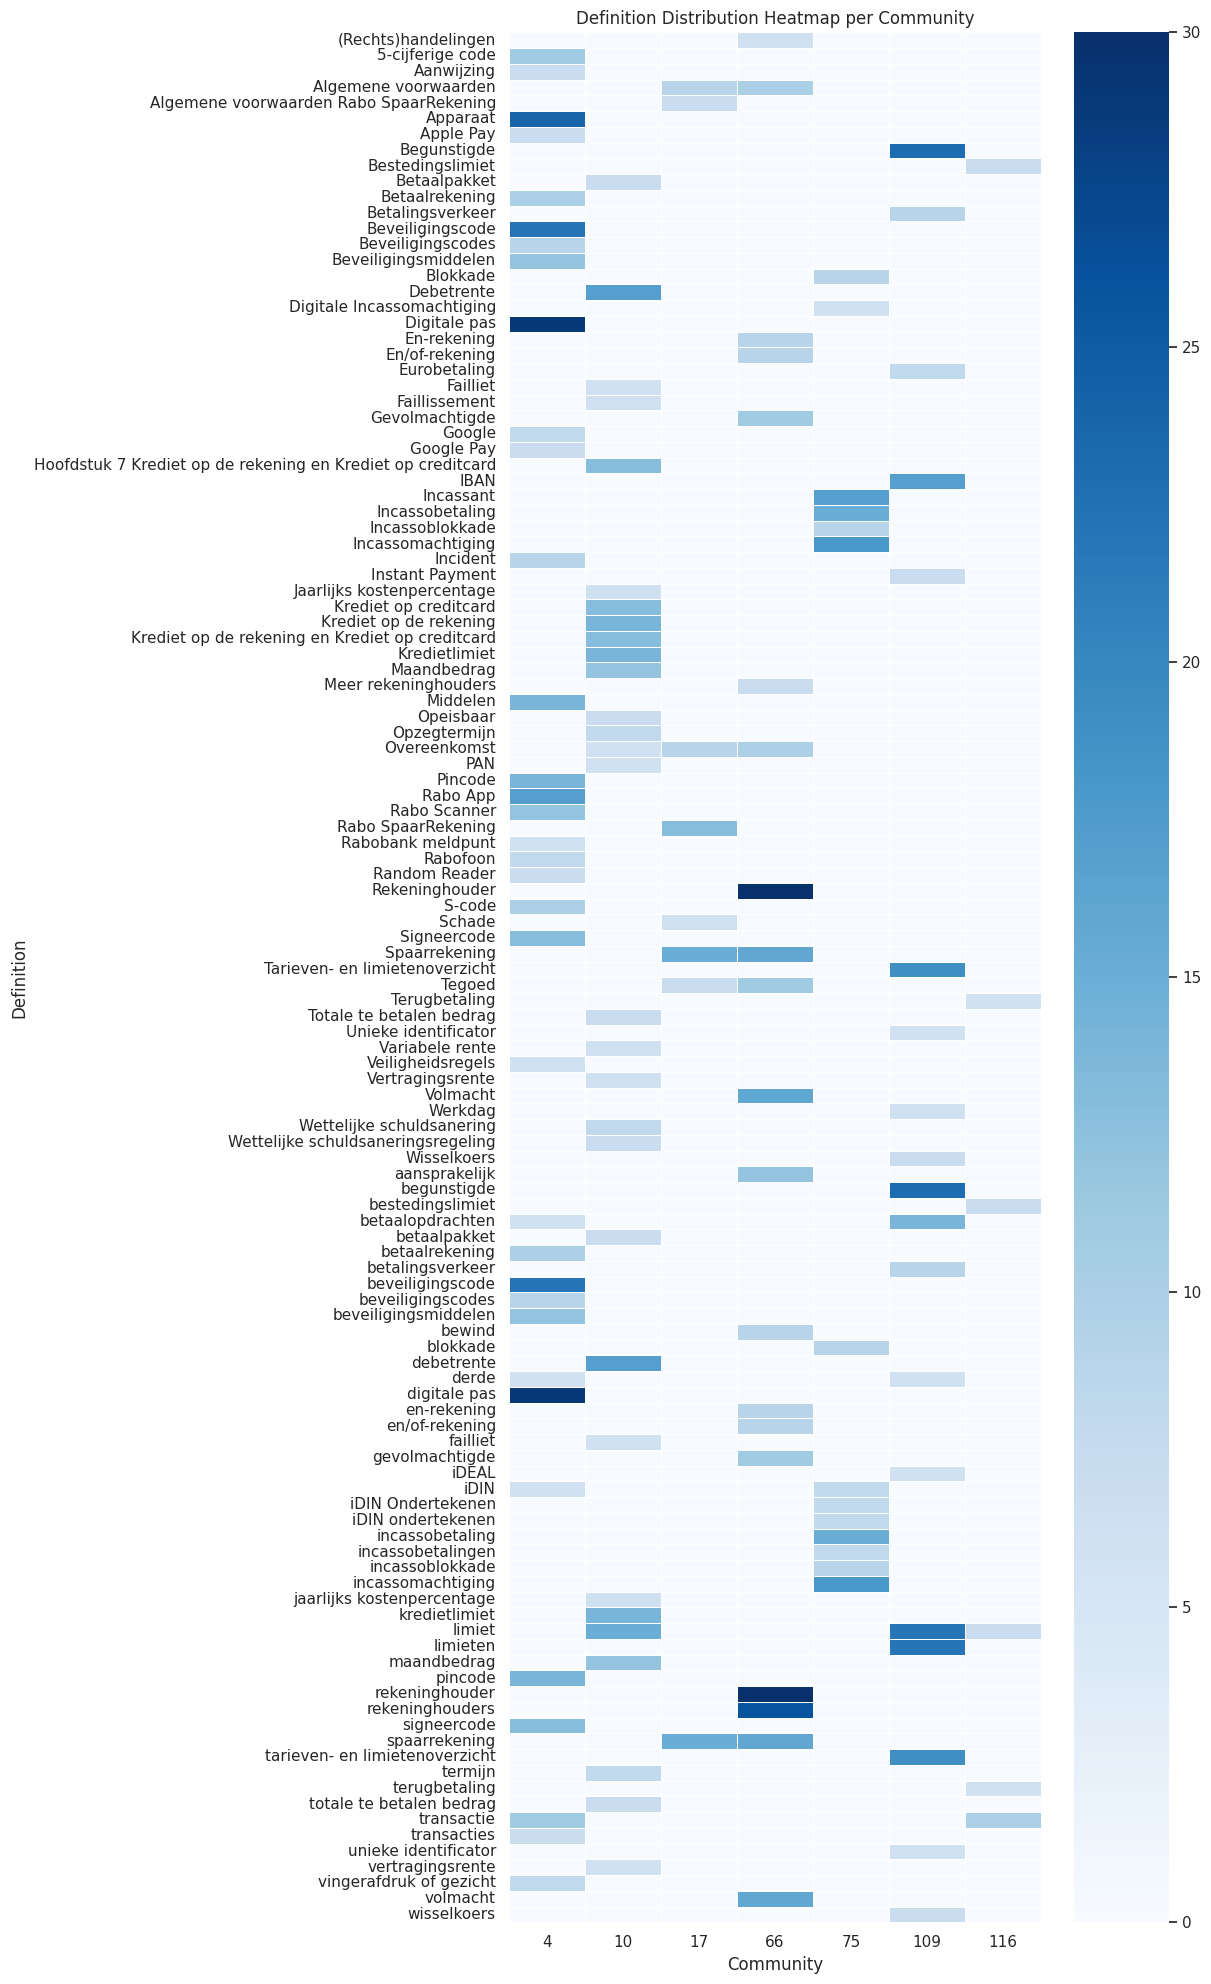

In [142]:
pivot_table = df.pivot(index="definition", columns="leiden_community", values="cnt").fillna(0).sort_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 20))
sns.heatmap(pivot_table, cmap="Blues", yticklabels=True, linewidths=0.5)
plt.xlabel("Community")
plt.ylabel("Definition")
plt.title("Definition Distribution Heatmap per Community")
plt.tight_layout()
plt.show()